## **기본 설정**

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

## **붓꽃(iris) 데이터셋 & 로지스틱 회귀(시그모이드 함수)**

붓꽃(iris) 데이터셋을 이용하여 로지스틱 회귀를 이용한 분류에 활용되는 결정 경계를 설명한다.
아래 코드는 사이킷런에서 제공하는 붓꽃 데이터셋을 번치(Bunch) 자료형으로 불러온다. 

__참고:__ `Bunch` 자료형은 기본적으로 `dict` 자료형과 동일하다. 
차이점은 인덱싱을 속성(attribute)처럼 처리할 수 있다는 것 뿐이다.

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()

데이터셋에 사용된 키는 다음과 같다. 

In [ ]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

`'data'` 키에 해당하는 값은 (150, 4) 모양의 넘파이 어레이다.

- 150: 150개의 붓꽃 샘플
- 4: 네 개의 특성. 차례대로 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비.

아래 코드는 처음 5개의 샘플 데이터를 보여준다. 

__참고:__ 원래 `iris['data'][:5]`로 값을 확인하지만 `Bunch` 자료형이기에 아래와 같이 클래스의
속성 형식으로 확인할 수도 있다. 인용부호를 사용하지 않음에 주의해야 한다.

In [ ]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

`'target'` 키는 150개 붓꽃에 대한 품종을 1차원 어레이로 담고 있다.

- 0: 세토사(Iris-Setosa)
- 1: 버시컬러(Iris-Versicolor)
- 2: 버지니카(Iris-Virginica)

언급된 순서대로 50개씩 세 품종의 타깃이 저장되어 있으며, 
처음 5개의 샘플은 세토사 품종임을 아래처럼 확인할 수 있다.

In [ ]:
iris.target[:5]

array([0, 0, 0, 0, 0])

50번 인덱스부터는 버시컬러 품종이다.

In [ ]:
iris.target[50:55]

array([1, 1, 1, 1, 1])

100번 인덱스부터는 버지니카 품종이다.

In [ ]:
iris.target[100:105]

array([2, 2, 2, 2, 2])

이런 정보가 `'DESCR'` 속성에 저장되어 있다.

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### 이진 분류: 로지스틱 회귀

로지스틱 회귀는 기본적으로 이진 분류 모델이며, 일대다(OvR) 전략을 이용하여 다중 클래스 분류도 지원한다.
하지만 다중 클래스를 기본으로 지원하는 __소프트맥스 회귀__를 잠시 뒤에 소개한다.

__예제 1__

아래 코드는 이진 분류 설명을 위해 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에
사용되는 데이터셋을 지정한다.

In [ ]:
X = iris["data"][:, 3:]                   # 1개의 특성(꽃잎 너비)만 사용
y = (iris["target"] == 2).astype(np.int)  # 버지니카(Virginica) 품종일 때 1(양성)

이제 사이킷런의 LogisticRegression 모델을 훈련시킨다.

**참고**: 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

1000개의 샘플을 새로 생성하여 훈련된 로지스틱 회귀 모델의 예측 결과를 도표로 확인하면 다음과 같다.

* `X_new`: 0~3구간을 1000등분한 값 1000개. 즉, 꽃잎의 너비를 0에서 3사이에서 1000개 선택.
* `y_proba`: 각 샘플에 대한 양성 확률
- x 축: 꽃잎 너비 크기
- 초록 실선: 버지니카(양성) 확률
- 파랑 점선: 버지니카가 아닌(음성) 확률

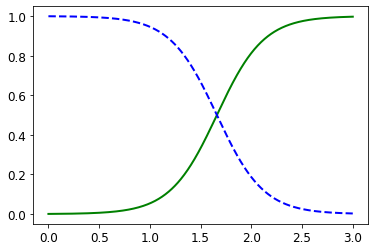

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

&#x270b; 아래 코드는 보다 많은 정보를 도표와 함께 전달한다.

- y=1.0를 지난 수평선
- x=1.66 근처의 결정 경계(decision boundary): 검은 수직 점선
- 초록 삼각형: 버지니카 품종
- 파랑 사각형: 버지니카 아닌 품종

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


그림 저장: logistic_regression_plot


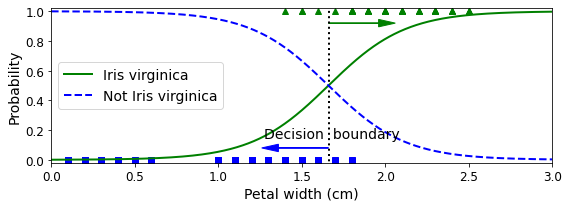

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

양성 확률이 0.5가 되는 꽃잎 너비의 길이, 즉 결정 경계는 1.66이다. 

In [ ]:
decision_boundary

array([1.66066066])

실제로 1.66보다 크면 양성, 작으면 음성으로 판정한다.

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

__예제 2__

아래 코드는 이진 분류 설명을 위해 꽃잎 길이와 너비 두 개의 특성을 이용하여 
버지니카 품종 여부를 판정하는 모델을 훈련한다.

In [ ]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

훈련 결과를 도표로 그리면 다음과 같다.

- 검은 실선: 결정 경계
- 다른 직선들: 버지니카(양성) 추정 확률별 결정 경계를 보여줌.

그림 저장: logistic_regression_contour_plot


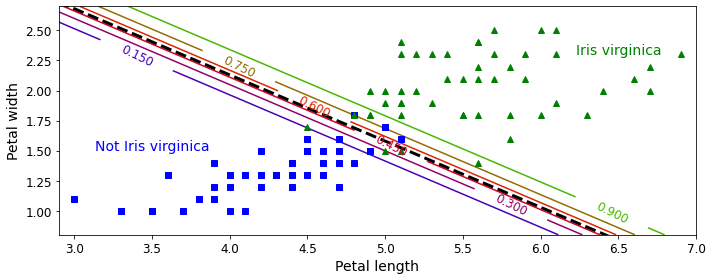

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

## **과제 1: 조기 종료 & 배치 경사 하강법 시그모이드 함수(사이킷런 미활용)**

조기 종료를 사용한 배치 경사 하강법으로 로지스틱 회귀를 구현하라.
단, 사이킷런을 전혀 사용하지 않아야 한다.

__단계 1: 데이터 준비__ 

아래 코드는 이진 분류 설명을 위해 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에
사용되는 데이터셋을 지정한다.

In [ ]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(np.int)

In [ ]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [ ]:
np.random.seed(2042)

__단계 2: 데이터셋 분할__ 

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

- 훈련 세트: 60%
- 검증 세트: 20%
- 테스트 세트: 20%

아래 코드는 사이킷런의 `train_test_split()` 함수를 사용하지 않고 
수동으로 무작위 분할하는 방법을 보여준다.
먼저 각 세트의 크기를 결정한다.

In [ ]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X_with_bias)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다. 

In [ ]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다.
방법은 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 것이다.

In [ ]:
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

__단계 3: 타깃 변환__ 

타깃은 0, 1로 설정되어 있다. 차례대로 버지니카가 아닌 품종, 버지니카 품종을 가리킨다.
훈련 세트의 첫 5개 샘플의 품종은 다음과 같다.

In [ ]:
y_train[:5]

array([0, 0, 1, 0, 0])

학습을 위해 타깃을 원-핫 벡터로 변환해야 한다. 
이유는 소프트맥스 회귀는 샘플이 주어지면 각 클래스별로 속할 확률을 구하고
구해진 결과를 실제 확률과 함께 이용하여 비용함수를 계산하기 때문이다. 

붓꽃 데이터의 경우 세 개의 품종 클래스별로 속할 확률을 계산해야 하기 때문에 
품종을 0, 1의 하나의 숫자로 두기 보다는 해당 클래스는 1, 나머지는 0인
확률값으로 이루어진 어레이로 다루어야 소프트맥스 회귀가 계산한 클래스별 확률과 
연결된다.

아래 함수 `to_one_hot()` 함수는 길이가 m이면서 0, 1로 이루어진 1차원 어레이가 입력되면
(m, 2) 모양의 원-핫 벡터를 반환한다.

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1                 # 클래스 수
    m = len(y)                              # 샘플 수
    Y_one_hot = np.zeros((m, n_classes))    # (샘플 수, 클래스 수) 0-벡터 생성
    Y_one_hot[np.arange(m), y] = 1          # 샘플 별로 해당 클래스의 값만 1로 변경. (넘파이 인덱싱 활용)
    return Y_one_hot

샘플 5개에 대해 잘 작동하는 것을 확인할 수 있다.

In [ ]:
y_train[:5]

array([0, 0, 1, 0, 0])

In [ ]:
to_one_hot(y_train[:5])

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

이제 훈련/검증/테스트 세트의 타깃을 모두 원-핫 벡터로 변환한다.

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

__단계 4: 로지스틱 회귀 시그모이드 함수__ 

In [ ]:
def sigmoid(logits):
    sig = 1 / (1 + np.exp(-logits))                  # 시그모이드 함수 식
    return sig 

__단계 5: 경사하강법 활용 훈련__ 

경사하강법을 구현하기 위해 아래 비용함수와 비용함수의 그레이디언트를 파이썬으로 
구현할 수 있어야 한다.

- 비용 함수($K$는 클래스 수, $m$은 샘플 수):

$$
J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$$

- 그레이디언트 공식(클래스 $k$에 대해):

$$
\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

__주의사항:__ 
수학적으로 $\hat{p}_k^{(i)} = 0$이면 
$\log\left(\hat{p}_k^{(i)}\right)$는 정의되지 않는다.
`NaN` 값을 피하기 위해 
$\hat{p}_k^{(i)}$에 작은 값 `epsilon` 추가한다.
여기서는 `1e-7`을 사용한다. 
사실 너무 작은 `epsilon`을 0에 더하면
컴퓨터가 그래도 0으로 취급할 수 있음에 조심해야 한다.

이제 훈련 코드를 작성할 수 있다.
클래스별 파라미터로 이루어진 $(n+1, K)$ 행렬 모양의 2차원 넘파이 어레이 $\Theta$를 
생성하기 위해 $n$과 $K$를 확인한다.

In [ ]:
n_inputs = X_train.shape[1]           # 특성 수(n) + 1, 붓꽃의 경우: 특성 2개 + 1
n_outputs = len(np.unique(y_train))   # 중복을 제거한 클래스 수(K), 붓꽃의 경우: 3개

파라미터 $\Theta$를 무작위로 초기 설정한다.

In [ ]:
Theta = np.random.randn(n_inputs, n_outputs)

배치 경사하강법 훈련은 아래 코드를 통해 이루어진다.

- `eta = 0.01`: 학습률
- `n_iterations = 5001` : 에포크 수
- `m = len(X_train)`: 훈련 세트 크기, 즉 훈련 샘플 수
- `epsilon = 1e-7`: $\log$ 값이 항상 계산되도록 더해지는 작은 실수
- `logits`: 모든 샘플에 대한 클래스별 점수, 즉 $\mathbf{X}_{\textit{train}}\, \Theta$
- `Y_proba`: 모든 샘플에 대해 계산된 클래스 별 소속 확률, 즉 $\hat P$

In [ ]:
#  배치 경사하강법 구현
eta = 0.008
n_iterations = 20001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):     # 20001번 반복 훈련
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
    
    if iteration % 1000 == 0:              # 1000 에포크마다 손실(비용) 계산해서 출력
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    
    error = Y_proba - Y_train_one_hot     # 그레이디언트 계산.
    gradients = 1/m * X_train.T.dot(error)
    
    Theta = Theta - eta * gradients       # 파라미터 업데이트

0 0.7505665677244439
1000 0.4804763206274273
2000 0.41052714358214226
3000 0.3677684056162294
4000 0.338602752400534
5000 0.31712937163117505
6000 0.3004458644844975
7000 0.2869673202781083
8000 0.2757539915016319
9000 0.26621136946706836
10000 0.25794341251343855
11000 0.2506750168780993
12000 0.24420839315801782
13000 0.23839719317579688
14000 0.23313046840028445
15000 0.22832234114153505
16000 0.22390513457121133
17000 0.2198246727795877
18000 0.21603698524324255
19000 0.21250594536404507
20000 0.20920154545577957


학습된 파라미터는 다음과 같다.

In [ ]:
Theta

array([[ 6.63293556, -6.19531144],
       [-0.3701003 ,  0.10952161],
       [-2.94571424,  3.46140596]])

검증 세트에 대한 예측과 정확도는 다음과 같다.
`logits`, `Y_proba`를 검증 세트인 `X_valid`를 이용하여 계산한다.
예측 클래스는 `Y_proba`에서 가장 큰 값을 갖는 인덱스로 선택한다.

In [ ]:
logits = X_valid.dot(Theta)              
Y_proba = sigmoid(logits)
y_predict = np.argmax(Y_proba, axis=1)          # 가장 높은 확률을 갖는 클래스 선택

accuracy_score = np.mean(y_predict == y_valid)  # 정확도 계산
accuracy_score

0.9666666666666667

__단계 6: 규제가 추가된 경사하강법 활용 훈련__ 

$\ell_2$ 규제가 추가된 경사하강법 훈련을 구현한다. 
코드는 기본적으로 동일하다.
다만 손실(비용)에 $\ell_2$ 페널티가 추가되었고 
그래디언트에도 항이 추가되었다(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않습니다). 

- 학습률 `eta` 증가됨.
- `alpha = 0.1`: 규제 강도

In [ ]:
eta = 0.008
n_iterations = 20001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1        # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
    
    if iteration % 1000 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))  # 편향은 규제에서 제외
        loss = xentropy_loss + alpha * l2_loss        # l2 규제가 추가된 손실
        print(iteration, loss)
    
    error = Y_proba - Y_train_one_hot
    l2_loss_gradients = np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]   # l2 규제 그레이디언트
    gradients = 1/m * X_train.T.dot(error) + l2_loss_gradients
    
    Theta = Theta - eta * gradients

0 0.33378492575068963
1000 0.49434322777154
2000 0.4355305367449598
3000 0.4124696788537583
4000 0.4006428414257761
5000 0.39368330211232105
6000 0.38936673547714856
7000 0.3866743621604194
8000 0.38504755389364487
9000 0.38414646891982535
10000 0.38375109735397783
11000 0.38371296418442136
12000 0.38392877480960247
13000 0.3843249641089864
14000 0.38484816968171187
15000 0.3854591253110464
16000 0.3861286201666072
17000 0.38683475169489867
18000 0.3875610138629505
19000 0.3882949393280328
20000 0.38902711762968356


In [ ]:
Theta

array([[ 5.4450137 , -5.2783609 ],
       [-0.90394829,  0.87334938],
       [-0.58323251,  0.57735928]])

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = sigmoid(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

__단계 7: 조기 종료 추가__

위 규제가 사용된 모델의 훈련 과정에서
매 에포크마다 검증 세트에 대한 손실을 계산하여 오차가 줄어들다가 증가하기 시작할 때 멈추도록 한다.

In [ ]:
eta = 0.008
n_iterations = 20001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1            # 규제 하이퍼파라미터
best_loss = np.infty   # 최소 손실값 기억 변수

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    # 검증 세트에 대한 손실 계산
    logits = X_valid.dot(Theta)
    Y_proba = sigmoid(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    
    # 1000 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 1000 == 0:
        print(iteration, loss)
        
    # 에포크마다 최소 손실값 업데이트
    if loss < best_loss:
        best_loss = loss
    else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, best_loss)        # 종료되지 이전 에포크의 손실값 출력
        print(iteration, loss, "조기 종료!")
        break

0 0.38520207611430535
0 0.38520207611430535
1 0.3886293636916429 조기 종료!


In [ ]:
Theta

array([[-0.50057877, -1.55863498],
       [ 0.92208839, -0.05329011],
       [-0.09270044,  1.39373802]])

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = sigmoid(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.6666666666666666

정확도는 떨어졌지만, 데이터가 적거나 운이 나쁜 경우일 것이다.

## **과제 2: 과제 1 + 다중 클래스 분류**

과제 1에서 구현된 로지스틱 회귀 알고리즘에 일대다(OvR) 방식을 적용하여 붓꽃에 대한 다중 클래스 분류 알고리즘을 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.

In [ ]:
np.random.seed(2042)

데이터 전처리 def 정의

In [ ]:
def datasetting(X, y):
  X_with_bias = np.c_[np.ones([len(X), 1]), X]

  test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
  validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
  total_size = len(X_with_bias)                            # 전체 데이터셋 크기

  test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
  validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
  train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%
  rnd_indices = np.random.permutation(total_size)

  X_train = X_with_bias[rnd_indices[:train_size]]
  y_train = y[rnd_indices[:train_size]]

  X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
  y_valid = y[rnd_indices[train_size:-test_size]]

  X_test = X_with_bias[rnd_indices[-test_size:]]
  y_test = y[rnd_indices[-test_size:]]

  Y_train_one_hot = to_one_hot(y_train)
  Y_valid_one_hot = to_one_hot(y_valid)
  Y_test_one_hot = to_one_hot(y_test)
  
  return X_train, y_train, X_valid, y_valid, X_test, y_test, Y_train_one_hot, Y_valid_one_hot, Y_test_one_hot

iris 데이터셋(붓꽃 데이터)가 50 단위로 나뉘는데, 각각 품종에 따른 Theta값 구하기

In [ ]:
i=0
a=50
b=[]
while i < 150:
  X = iris["data"][i:a][:, (2, 3)]                  # 꽃잎 길이와 너비
  y = iris["target"][i:a]
  datasetting(X, y)

  n_inputs = X_train.shape[1]           # 특성 수(n) + 1, 붓꽃의 경우: 특성 2개 + 1
  n_outputs = len(np.unique(y_train))   # 중복을 제거한 클래스 수(K), 붓꽃의 경우: 3개
  Theta = np.random.randn(n_inputs, n_outputs)

  eta = 0.008
  n_iterations = 20001
  m = len(X_train)
  epsilon = 1e-7
  alpha = 0.1            # 규제 하이퍼파라미터
  best_loss = np.infty   # 최소 손실값 기억 변수

  Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

  for iteration in range(n_iterations):
      # 훈련 및 손실 계산
      logits = X_train.dot(Theta)
      Y_proba = sigmoid(logits)
      error = Y_proba - Y_train_one_hot
      gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
      Theta = Theta - eta * gradients
      
      # 검증 세트에 대한 손실 계산
      logits = X_valid.dot(Theta)
      Y_proba = sigmoid(logits)
      xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
      l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
      loss = xentropy_loss + alpha * l2_loss
      
      # 1000 에포크마다 검증 세트에 대한 손실 출력
      if iteration % 1000 == 0:
          print(iteration, loss)
          
      # 에포크마다 최소 손실값 업데이트
      if loss < best_loss:
          best_loss = loss
      else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
          print(iteration - 1, best_loss)        # 종료되지 이전 에포크의 손실값 출력
          print(iteration, loss, "조기 종료!")
          break
  i += 50
  a += 50
  b.append(Theta)

0 1.218616855424293
51 0.5708859411839247
52 0.5710125527237332 조기 종료!
0 0.682982725354496
14 0.6734147955234785
15 0.673496410423033 조기 종료!
0 2.418209167132795
1000 0.6113601403774309
2000 0.5107233368931612
3000 0.4662777684751965
4000 0.441642222484412
5000 0.4266222467528403
6000 0.4170598081296712
7000 0.4108476130927281
8000 0.4067957076033864
9000 0.4041874847488671
10000 0.4025705728246626
11000 0.40164830673059193
12000 0.4012198564858454
12745 0.401136937356851
12746 0.40113693743151896 조기 종료!


Theta 값들을 비교하여 best Theta 값 찾기

In [ ]:
i = 0
best_Y_proba = []

while i < 3:
  logits = X_valid.dot(b[i])
  Y_proba = sigmoid(logits)
  best_Y_proba.append(Y_proba)
  i+=1

In [ ]:
w1 = best_Y_proba[0]
w2 = best_Y_proba[1]
w3 = best_Y_proba[2]

In [ ]:
i = 0
w4 = np.zeros((30, 2))

while i < len(w1):
  if w1[i,0] > w2[i,0]:
    w4[i,0] = w1[i,0]
  else:
    w4[i,0] = w2[i,0]
  if w3[i,0] > w4[i,0]:
    w4[i,0] = w3[i,0]

  if w1[i,1] > w2[i,1]:
    w4[i,1] = w1[i,1]
  else:
    w4[i,1] = w2[i,1]
  if w3[i,1] > w4[i,1]:
    w4[i,1] = w3[i,1]
  i+=1

가장 좋은 성능을 보이는 Theta 값을 찾음

In [ ]:
y_predict = np.argmax(w4, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.6